# Pilot RBD depletions with B.1.351 protein and plasmas

### Set up Analysis

Import packages.

In [14]:
import itertools
import math
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt
from mizani.formatters import scientific_format
import natsort

import numpy as np
import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import lifelines
import sklearn
import scipy.stats

import yaml

In [15]:
warnings.simplefilter('ignore')

Use seaborn theme and change font:

In [16]:
theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))
plt.style.use('seaborn-white')

Read config file:

In [17]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [18]:
datadir=config['elisa_data_dir']

resultsdir='results/rbd_depletion_elisas'
os.makedirs(resultsdir, exist_ok=True)

In [19]:
pd.options.display.max_rows = 100

In [20]:
data = os.path.join(datadir, '210415_ELISA_pilot_RE.csv')

titration_df = (pd.read_csv(data)
                .melt(
                        id_vars=['serum', 'depleted', 'ratio_beads', 'amount_RBD_protein', 'ligand', 'date'], 
                        var_name='dilution_factor', 
                        value_name='OD450'
                       )
                .assign(dilution_factor=lambda x: x['dilution_factor'].astype(int),
                        dilution=lambda x: 1/x['dilution_factor'],
                        amount_RBD_protein=lambda x: pd.Categorical(x['amount_RBD_protein'], natsort.natsorted(x['amount_RBD_protein'].unique())[::-1], ordered=True)
                       )
                .replace({'2to1':'2:1 beads', '1to1':'1:1 beads'})
               )

display(titration_df.head(2))  # display first few lines

,serum,depleted,ratio_beads,amount_RBD_protein,ligand,date,dilution_factor,OD450,dilution
0,CR3022,mock 1:1,1:1 beads,none,B.1.351 RBD,210415,100,3.41205,0.01
1,CR3022,10 ug/mg beads 1:1,1:1 beads,10 ug/mg beads,B.1.351 RBD,210415,100,3.27480,0.01


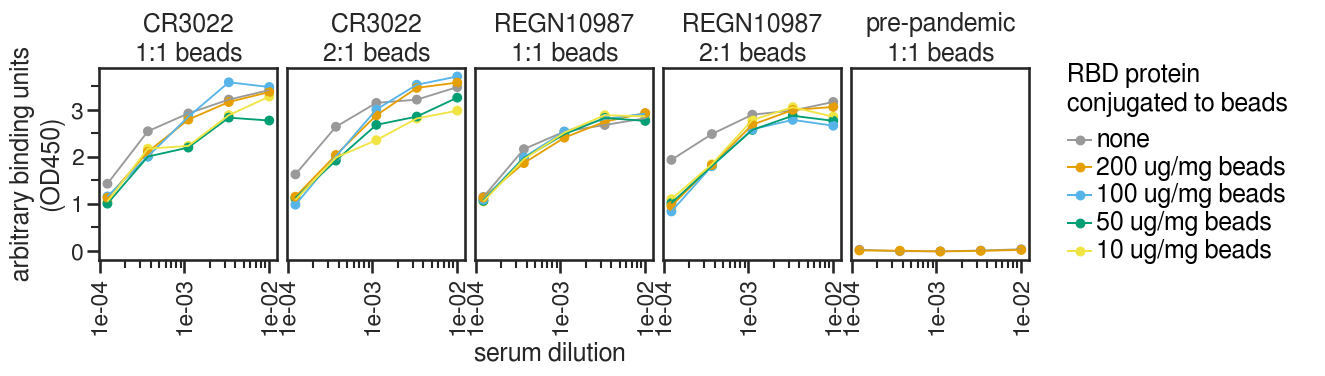

In [21]:
nconditions = titration_df['serum'].nunique()
# ncol = np.minimum(6, nconditions)
ncol=6
nrow = math.ceil(nconditions / ncol)

p = (
    ggplot((titration_df),
           aes('dilution', 
               'OD450', 
               color='amount_RBD_protein',
               )) +
    geom_point(size=3) +
    geom_path(aes(color='amount_RBD_protein'), size=0.75) +
    scale_x_log10(name='serum dilution', labels=scientific_format(digits=0)) +
    facet_wrap('~ serum + ratio_beads ', ncol=ncol) +
    theme(figure_size=(2 * ncol, 2.5 * nrow),
          axis_text_x=element_text(angle=90),
          subplots_adjust={'hspace':1},
          strip_background=element_blank()
         ) +
    scale_color_manual(values=CBPALETTE[0:], name='RBD protein\nconjugated to beads') +
    ylab('arbitrary binding units\n(OD450)')
    )

_ = p.draw()

p.save(f'{resultsdir}/210415_pilot.pdf')

New experiment testing the free sample of commerical beads we got from Acro

In [22]:
data = os.path.join(datadir, '210507_ELISA_pilot_RE.csv')

titration_df = (pd.read_csv(data)
                .melt(
                        id_vars=['serum', 'depleted', 'ratio_beads', 'amount_RBD_protein', 'ligand', 'date'], 
                        var_name='dilution_factor', 
                        value_name='OD450'
                       )
                .assign(dilution_factor=lambda x: x['dilution_factor'].astype(int),
                        dilution=lambda x: 1/x['dilution_factor'],
                        amount_RBD_protein=lambda x: pd.Categorical(x['amount_RBD_protein'], natsort.natsorted(x['amount_RBD_protein'].unique())[::-1], ordered=True)
                       )
                .replace({'2to1':'2x 2:1 beads', '1to1':'1:1 beads',
                          'Acro_beads':'Acro RBD and beads conjugated by Acro',
                          'Rachel_beads':'Acro RBD and beads conjugated by Rachel',
                          'no_beads':'no beads',
                          'RBD':'Acro B.1.351\nRBD',
                          'spike':'IPD B.1.351\nspike'
                         }
                        )
               )

display(titration_df.head(2))  # display first few lines

,serum,depleted,ratio_beads,amount_RBD_protein,ligand,date,dilution_factor,OD450,dilution
0,CR3022,no beads,2x 2:1 beads,100ug,Acro B.1.351\nRBD,210507,100,3.9127,0.01
1,CR3022,Acro RBD and beads conjugated by Acro,2x 2:1 beads,100ug,Acro B.1.351\nRBD,210507,100,0.2540,0.01


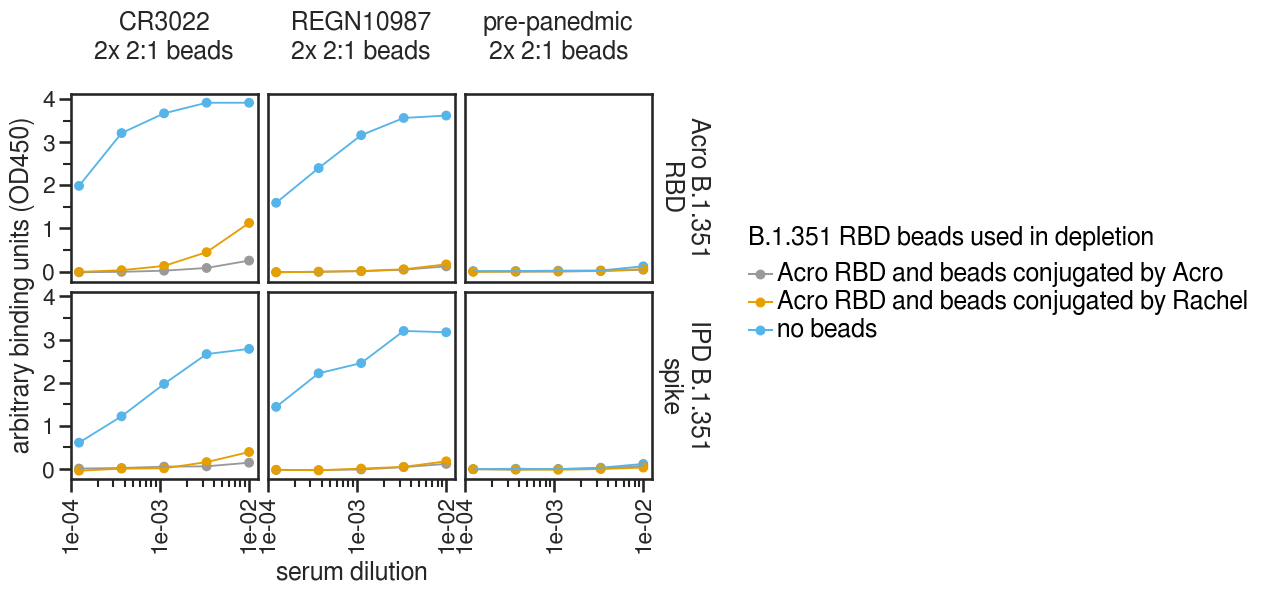

In [23]:
ncol=titration_df['serum'].nunique()
nrow =titration_df['ligand'].nunique()

p = (
    ggplot((titration_df),
           aes('dilution', 
               'OD450', 
               color='depleted',
               )) +
    geom_point(size=3) +
    geom_path(aes(color='depleted'), size=0.75) +
    scale_x_log10(name='serum dilution', labels=scientific_format(digits=0)) +
    facet_grid('ligand~ serum + ratio_beads') +
    theme(figure_size=(2.5 * ncol, 2.5 * nrow),
          axis_text_x=element_text(angle=90),
          strip_background=element_blank(),
          strip_margin_y=0.35,
         ) +
    scale_color_manual(values=CBPALETTE[0:], name='B.1.351 RBD beads used in depletion') +
    ylab('arbitrary binding units (OD450)')
    )

_ = p.draw()

p.save(f'{resultsdir}/210507_pilot.pdf')
p.save(f'{resultsdir}/210507_pilot.png')

## Depleting B.1.351 sera with the Acro beads
May 12, 2021
Rachel used the Acro beads, 2x depletions at 2:1 ratio

,serum,depleted,ratio_beads,amount_RBD_protein,ligand,date,dilution_factor,OD450,dilution
0,K006,mock,2x 2:1 beads,100ug,Acro B.1.351\nRBD,210512,100,0.0281,0.010000
1,K007,mock,2x 2:1 beads,100ug,Acro B.1.351\nRBD,210512,100,3.2543,0.010000
2,K031,mock,2x 2:1 beads,100ug,Acro B.1.351\nRBD,210512,100,3.4500,0.010000
3,K033,mock,2x 2:1 beads,100ug,Acro B.1.351\nRBD,210512,100,3.5232,0.010000
4,K040,mock,2x 2:1 beads,100ug,Acro B.1.351\nRBD,210512,100,3.6484,0.010000
...,...,...,...,...,...,...,...,...,...
475,REGN10987,mock,2x 2:1 beads,100ug,IPD B.1.351\nspike,210512,16200,0.8484,0.000062
476,K115,2x 2:1 depleted,2x 2:1 beads,100ug,IPD B.1.351\nspike,210512,16200,NaN,0.000062
477,K116,2x 2:1 depleted,2x 2:1 beads,100ug,IPD B.1.351\nspike,210512,16200,NaN,0.000062
478,K119,2x 2:1 depleted,2x 2:1 beads,100ug,IPD B.1.351\nspike,210512,16200,NaN,0.000062


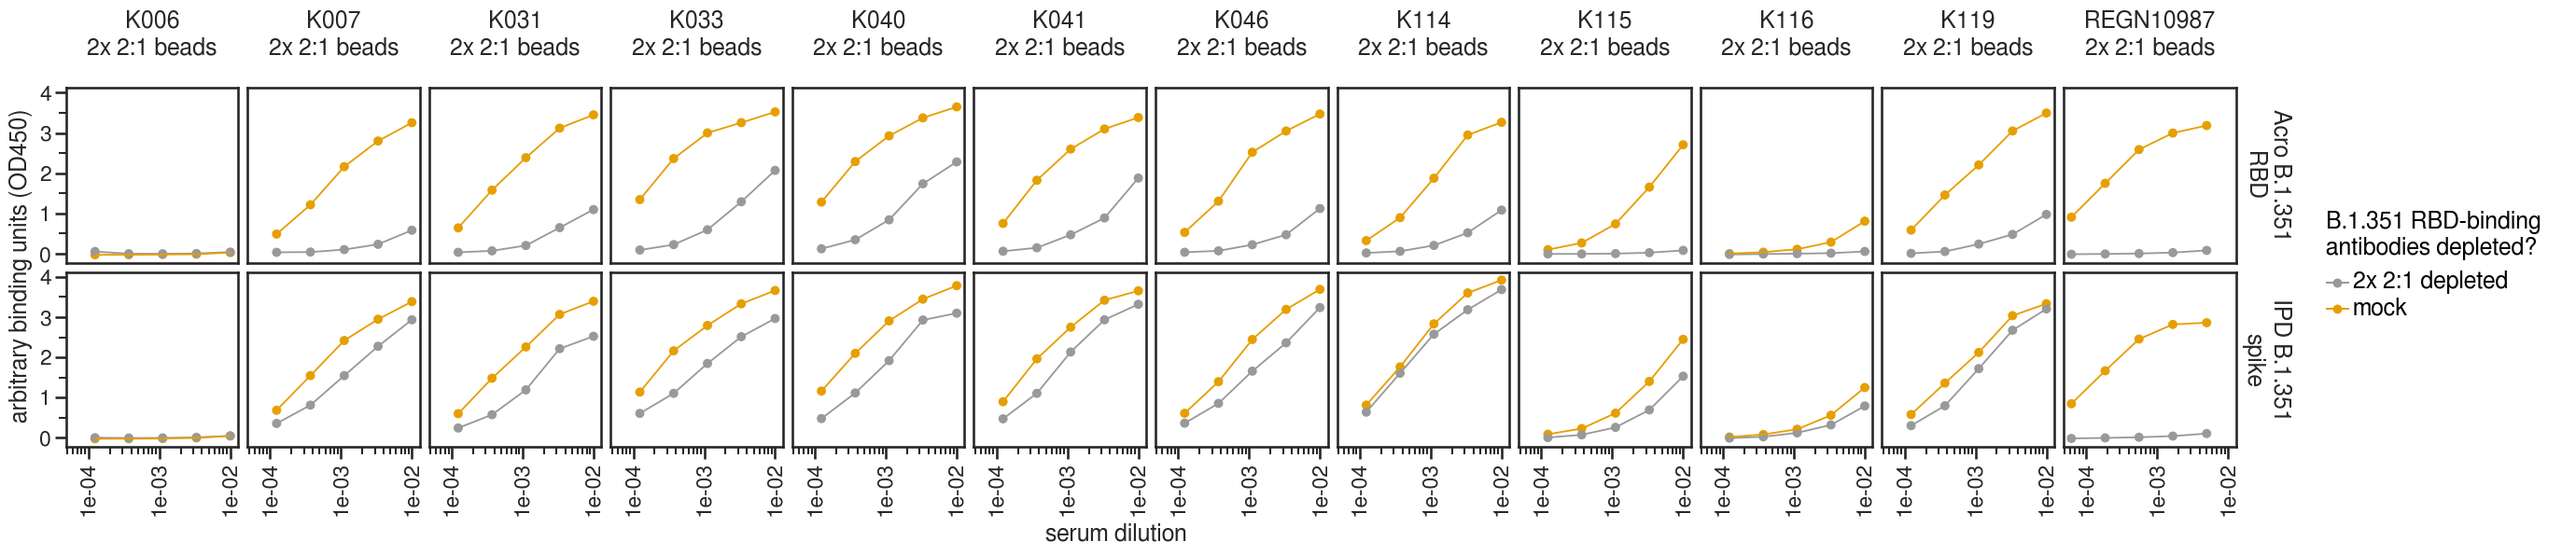

In [24]:
data = os.path.join(datadir, '210512_ELISA_2xdep.csv')

titration_df = (pd.read_csv(data)
                .melt(
                        id_vars=['serum', 'depleted', 'ratio_beads', 'amount_RBD_protein', 'ligand', 'date'], 
                        var_name='dilution_factor', 
                        value_name='OD450'
                       )
                .assign(dilution_factor=lambda x: x['dilution_factor'].astype(int),
                        dilution=lambda x: 1/x['dilution_factor'],
                       )
                .replace({'2to1':'2x 2:1 beads', '1to1':'1:1 beads',
                          'RBD':'Acro B.1.351\nRBD',
                          'spike':'IPD B.1.351\nspike'
                         }
                        )
               )

display(titration_df)  # display first few lines

ncol=titration_df['serum'].nunique()
nrow =titration_df['ligand'].nunique()

p = (
    ggplot((titration_df),
           aes('dilution', 
               'OD450', 
               color='depleted',
               )) +
    geom_point(size=3) +
    geom_path(aes(color='depleted'), size=0.75) +
    scale_x_log10(name='serum dilution', labels=scientific_format(digits=0)) +
    facet_grid('ligand~ serum + ratio_beads') +
    theme(figure_size=(2.5 * ncol, 2.5 * nrow),
          axis_text_x=element_text(angle=90),
          strip_background=element_blank(),
          strip_margin_y=0.35,
         ) +
    scale_color_manual(values=CBPALETTE[0:], name='B.1.351 RBD-binding\nantibodies depleted?') +
    ylab('arbitrary binding units (OD450)')
    )

_ = p.draw()

p.save(f'{resultsdir}/210512_ELISA.pdf', limitsize=False)
p.save(f'{resultsdir}/210512_ELISA.png', limitsize=False)

## 3rd round of depletions on 8 of the serum samples

From the above ELISAs, we learned:
* K006 is likely a false positive: we drop this sample from future experiments. 
* K115 and K116 are fully depleted
* All the others are not. 

So we depleted the samples a 3rd time. This time I used the "Rachel beads" that she conjugated with 100ug of Acro B.1.351 RBD protein per mg of Acro beads. Because these beads don't seem as efficient at depleting RBD-binding antibodies, I did a 3:1 beads:serum ratio (i.e., 90uL of beads for the original input of 30uL of serum). 

Rachel repeated ELISAs for these 8 samples, below. 

,serum,depleted,ratio_beads,amount_RBD_protein,ligand,date,dilution_factor,OD450,dilution
0,K007,mock,3x depleted,100ug,Acro B.1.351\nRBD,210513,100,3.8700,0.010000
1,K031,mock,3x depleted,100ug,Acro B.1.351\nRBD,210513,100,3.6259,0.010000
2,K033,mock,3x depleted,100ug,Acro B.1.351\nRBD,210513,100,3.5820,0.010000
3,K040,mock,3x depleted,100ug,Acro B.1.351\nRBD,210513,100,3.6621,0.010000
4,K041,mock,3x depleted,100ug,Acro B.1.351\nRBD,210513,100,3.8603,0.010000
...,...,...,...,...,...,...,...,...,...
155,K040,3x depleted,3x depleted,100ug,IPD B.1.351\nspike,210513,8100,0.5075,0.000123
156,K041,3x depleted,3x depleted,100ug,IPD B.1.351\nspike,210513,8100,0.5596,0.000123
157,K046,3x depleted,3x depleted,100ug,IPD B.1.351\nspike,210513,8100,0.3404,0.000123
158,K114,3x depleted,3x depleted,100ug,IPD B.1.351\nspike,210513,8100,0.7632,0.000123


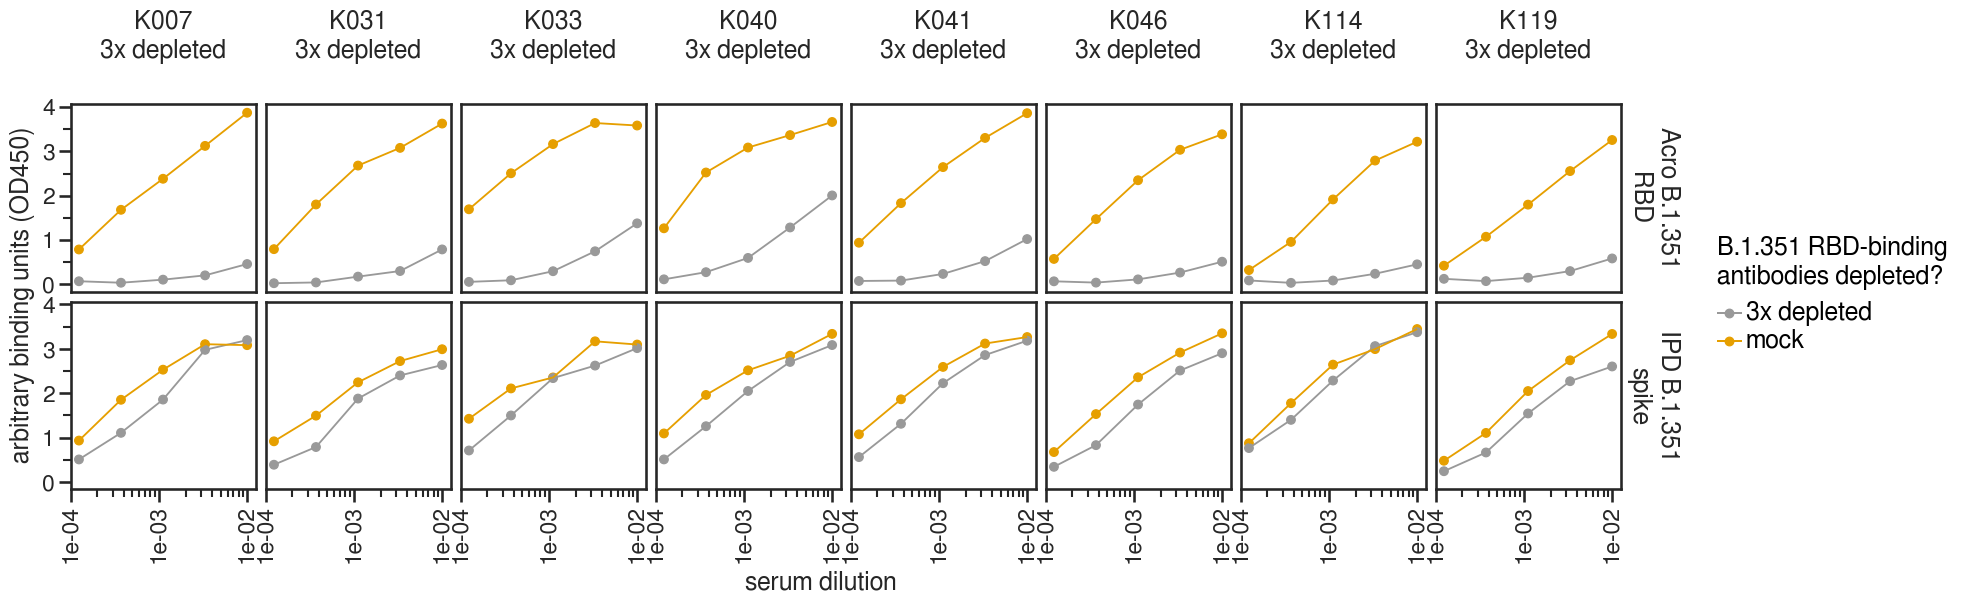

In [25]:
data = config['final_depletion_elisas']

titration_df = (pd.read_csv(data)
                .melt(
                        id_vars=['serum', 'depleted', 'ratio_beads', 'amount_RBD_protein', 'ligand', 'date'], 
                        var_name='dilution_factor', 
                        value_name='OD450'
                       )
                .assign(dilution_factor=lambda x: x['dilution_factor'].astype(int),
                        dilution=lambda x: 1/x['dilution_factor'],
                       )
                .replace({'3to1':'3x depleted',
                          'RBD':'Acro B.1.351\nRBD',
                          'spike':'IPD B.1.351\nspike'
                         }
                        )
               )

display(titration_df)  # display first few lines

ncol=titration_df['serum'].nunique()
nrow =titration_df['ligand'].nunique()

p = (
    ggplot((titration_df),
           aes('dilution', 
               'OD450', 
               color='depleted',
               )) +
    geom_point(size=3) +
    geom_path(aes(color='depleted'), size=0.75) +
    scale_x_log10(name='serum dilution', labels=scientific_format(digits=0)) +
    facet_grid('ligand~ serum + ratio_beads') +
    theme(figure_size=(2.5 * ncol, 2.5 * nrow),
          axis_text_x=element_text(angle=90),
          strip_background=element_blank(),
          strip_margin_y=0.5,
         ) +
    scale_color_manual(values=CBPALETTE[0:], name='B.1.351 RBD-binding\nantibodies depleted?') +
    ylab('arbitrary binding units (OD450)')
    )

_ = p.draw()

p.save(f'{resultsdir}/210513_ELISA.pdf', limitsize=False)
p.save(f'{resultsdir}/210513_ELISA.png', limitsize=False)

Plot May 12 2x depletions and May 13 3x depletions on same axis

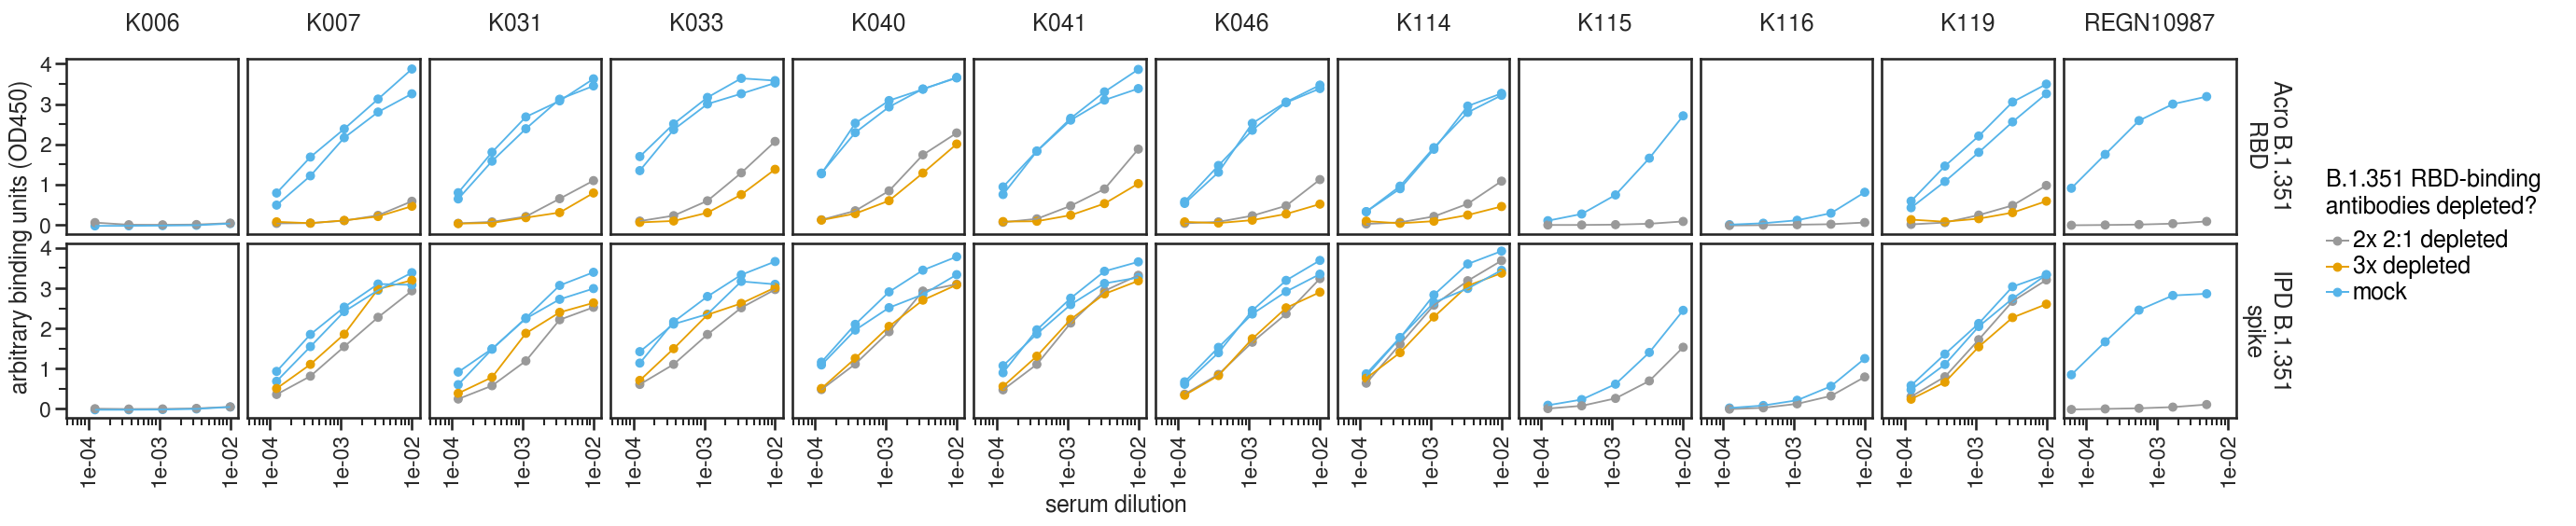

In [27]:
titration_df = pd.DataFrame()

for f in ['210512_ELISA_2xdep.csv', '210513_ELISA_3xdep.csv']:

    df = (pd.read_csv(os.path.join(datadir, f))
                    .melt(
                            id_vars=['serum', 'depleted', 'ratio_beads', 'amount_RBD_protein', 'ligand', 'date'], 
                            var_name='dilution_factor', 
                            value_name='OD450'
                           )
                    .assign(dilution_factor=lambda x: x['dilution_factor'].astype(int),
                            dilution=lambda x: 1/x['dilution_factor'],
                           )
                    .replace({'RBD':'Acro B.1.351\nRBD',
                              'spike':'IPD B.1.351\nspike'
                             }
                            )
                   )
    titration_df=pd.concat([titration_df, df])

titration_df = titration_df.assign(depleted_date=lambda x: x['depleted']+'_'+x['date'].astype(str))

ncol=titration_df['serum'].nunique()
nrow =titration_df['ligand'].nunique()

p = (
    ggplot((titration_df),
           aes('dilution', 
               'OD450', 
               color='depleted',
               group='depleted_date',
               )) +
    geom_point(size=3) +
    geom_path(aes(color='depleted'), size=0.75) +
    scale_x_log10(name='serum dilution', labels=scientific_format(digits=0)) +
    facet_grid('ligand~ serum') +
    theme(figure_size=(2.5 * ncol, 2.5 * nrow),
          axis_text_x=element_text(angle=90),
          strip_background=element_blank(),
          strip_margin_y=0.5,
         ) +
    scale_color_manual(values=CBPALETTE[0:], name='B.1.351 RBD-binding\nantibodies depleted?') +
    ylab('arbitrary binding units (OD450)')
    )

_ = p.draw()

p.save(f'{resultsdir}/2x3xdepletions_ELISA.pdf', limitsize=False)
p.save(f'{resultsdir}/2x3xdepletions_ELISA.png', limitsize=False)

titration_df.to_csv(f'{resultsdir}/rbd_depletion_elisas.csv', index=False)